In [16]:
# falta ultima parte

In [17]:
# 10/03/2022 Luís

# In this notebook, in addition to the "train_HGO_diff" notebook,
# the parameters [c, κ, k1, k2, θ] were normalized using sklearn.preprocessing.StandardScaler()
# This way, each of the components of the vector is normaly distributed around 0 with a standard deviation of 1.

# For example, for c, mean = 20.59518917 and std = 12.4038047.
# A original value of 13.78172437 will be transformed into -0.54930442. (z = (x – mean) / std)

# Lower losses were achieved with this normalization.



# 28/03/2022 Luís

# In this notebook I use a total set of 537824 (14^5) curves. The model only predicts the stress value, as the stretch values
# were the same for all curves.

# In the end of the notebook, the test labels and model outputs are transformed back into absolute coordinates
# (the model is trained on the differences between stress values) and I apply evaluation metrics to the model.

# Three metrics are applied: 

# MSE (average error across all test curves)

# R^2 score (average score across all test curves)
#           (accuracy score defined as the percentage of curves that have a score above an accepteble treshold)

# Relative error (average error across all test curves)
#                (accuracy score defined as the percentage of curves that have an error below an accepteble treshold)

# I have a spreadsheet with these metrics applied on similar models which were trained on 10^5; 12^5; 14^5 and 16^5 curves.

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [20]:
import pandas as pd
import random

#import sympy as sym
#from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

#pd.set_option('display.max_rows', None)

In [21]:
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [22]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

### Import data

#### In this case we have 537824 total curves (= 14^5)

In [23]:
X = np.load('X_sh_14_20.npy')
y = np.load('y_sh_14_20.npy')

In [24]:
ninc = np.shape(y)[1] + 1 # number of points per curve, in this case ninc = 20

In [25]:
x_vec = np.linspace(1.0,1.6,ninc)

### Now we are ready to seperate our data into a training set and a test set

In [26]:
#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)

#reshape for keras training
#y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (484041, 5)
Test set:  (53783, 5)
 
Features
Training set:  (484041, 19, 2)
Test set:  (53783, 19, 2)


In [27]:
np.shape(x_train)

(484041, 5)

In [28]:
np.shape(y_train)

(484041, 19, 2)

### And now we can build our model and train it

In [49]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.3
LEARNING_RATE = 0.00002
BATCH_SIZE = 256
EPOCHS = 12
INPUT_SHAPE = x_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1:]

# Set the model's architechture
inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(1024, activation="relu")
x = dense(inputs)



dense = layers.Dense(1024, activation="relu")
x = dense(x)



dense = layers.Dense(1024, activation="relu")
x = dense(x)



dense = layers.Dense((ninc-1)*50, activation="relu")
x = dense(x)

#dropout = tf.keras.layers.Dropout(0.2)
#x = dropout(x)

x = tf.keras.layers.Reshape((ninc-1, -1))(x)

dense = layers.Dense(128, activation="relu")
x = dense(x)

dropout = tf.keras.layers.Dropout(0.2)
x = dropout(x)

outputs = layers.Dense(2)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")


# Compile, define the loss function, the optimizer and other metrics
model.compile(
    loss = tf.keras.losses.Huber(),
   # optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay = LEARNING_RATE/EPOCHS),
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              6144      
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_19 (Dense)             (None, 950)               973750    
_________________________________________________________________
reshape_2 (Reshape)          (None, 19, 50)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 19, 128)           6528  

In [50]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

#print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/12
1324/1324 [==============================] - 10s 7ms/step - loss: 1.6924 - mean_squared_error: 4555.8535 - val_loss: 1.3624 - val_mean_squared_error: 5605.4863
Epoch 2/12
1324/1324 [==============================] - 9s 7ms/step - loss: 1.0685 - mean_squared_error: 3767.6338 - val_loss: 0.9444 - val_mean_squared_error: 4457.6113
Epoch 3/12
1324/1324 [==============================] - 9s 7ms/step - loss: 0.7530 - mean_squared_error: 2845.4907 - val_loss: 0.6732 - val_mean_squared_error: 3432.7866
Epoch 4/12
1324/1324 [==============================] - 9s 7ms/step - loss: 0.5525 - mean_squared_error: 2097.6184 - val_loss: 0.4943 - val_mean_squared_error: 2627.5549
Epoch 5/12
1324/1324 [==============================] - 9s 7ms/step - loss: 0.4263 - mean_squared_error: 1581.7334 - val_loss: 0.4019 - val_mean_squared_error: 2010.3032
Epoch 6/12
1324/1324 [==============================] - 9s 7ms/step - loss: 0.3463 - mean_squared_error: 1155.3624 - val_loss: 0.3116 - val_mean_squa

0.9266583472490311


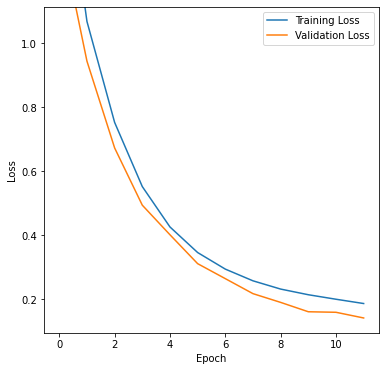

In [51]:
plt.rcParams["figure.figsize"] = (6,6)

epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [52]:
model.predict(x_test[0:1])[0]

array([[ 4.2026963,  2.0069048],
       [ 4.1316953,  1.8625436],
       [ 4.0162477,  1.7231717],
       [ 3.9910326,  1.5992496],
       [ 3.9057515,  1.4774917],
       [ 3.8561034,  1.3862401],
       [ 3.9823313,  1.3124884],
       [ 3.9155643,  1.1865326],
       [ 3.9763398,  1.1678797],
       [ 4.07674  ,  1.1121795],
       [ 4.2796926,  1.0914283],
       [ 4.37644  ,  1.062976 ],
       [ 4.736121 ,  1.1641558],
       [ 4.925429 ,  1.1956792],
       [ 5.511099 ,  1.2838402],
       [ 6.053371 ,  1.4819905],
       [ 7.6693273,  1.8788145],
       [ 9.290746 ,  2.4683425],
       [11.697591 ,  3.077992 ]], dtype=float32)

In [53]:
y_test[0:1][0]

array([[ 4.21848033,  2.05951111],
       [ 4.12160888,  1.88731249],
       [ 4.0472411 ,  1.73597547],
       [ 3.99348922,  1.60311129],
       [ 3.95926178,  1.48688379],
       [ 3.94431389,  1.38596887],
       [ 3.94938252,  1.29955212],
       [ 3.97643813,  1.22737031],
       [ 4.02910626,  1.16980979],
       [ 4.11334726,  1.12808437],
       [ 4.23854119,  1.1045316 ],
       [ 4.41922244,  1.10309224],
       [ 4.67787809,  1.13008191],
       [ 5.04951872,  1.19543893],
       [ 5.58925657,  1.31476469],
       [ 6.38507726,  1.51270767],
       [ 7.57974884,  1.82866883],
       [ 9.40911492,  2.32659568],
       [12.270357  ,  3.11212082]])

In [54]:
np.shape(model.predict(x_test[0:1])[0])

(19, 2)

In [55]:
def plot_real_curves(k):
    
    pred_diff = model.predict(x_test[k:k+1])[0][:,0]
    pred = np.zeros([len(pred_diff)+1])
    pred[0] = 0
    for i in range(len(pred_diff)):
        pred[i+1] = pred_diff[i] + pred[i]

    plt.plot(x_vec,pred, "--",  color = "g", label = "prediction_xx")

    
    true_dif = y_test[k:k+1][0][:,0]
    true = np.zeros([len(true_dif)+1])
    true[0] = 0
    for i in range(len(pred_diff)):
        true[i+1] = true_dif[i] + true[i]

    plt.plot(x_vec,true, color = "g", label = "real_xx")

    pred_diff = model.predict(x_test[k:k+1])[0][:,1]
    pred = np.zeros([len(pred_diff)+1])
    pred[0] = 0
    for i in range(len(pred_diff)):
        pred[i+1] = pred_diff[i] + pred[i]

    plt.plot(x_vec,pred, "--",  color = "r", label = "prediction_yy")

    
    true_dif = y_test[k:k+1][0][:,1]
    true = np.zeros([len(true_dif)+1])
    true[0] = 0
    for i in range(len(pred_diff)):
        true[i+1] = true_dif[i] + true[i]

    plt.plot(x_vec,true, color = "r", label = "real_yy")

    plt.xlabel("λ")
    plt.ylabel("σ")
    plt.legend()
    plt.show()

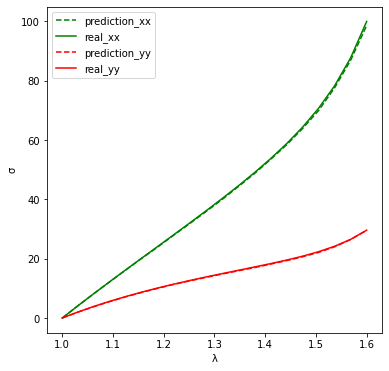

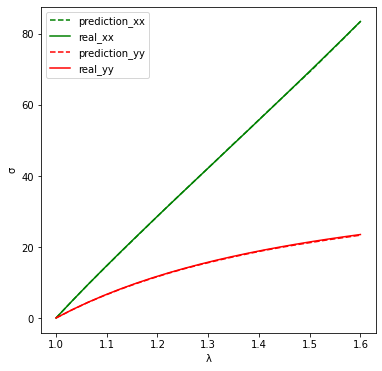

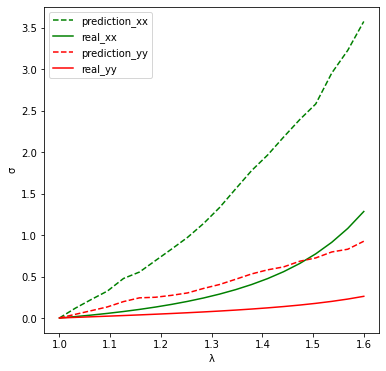

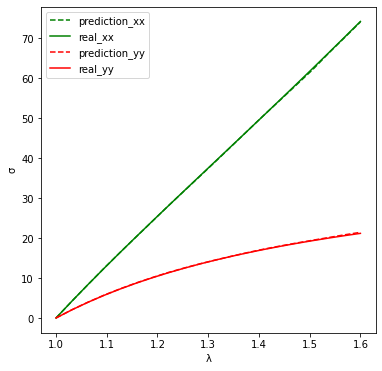

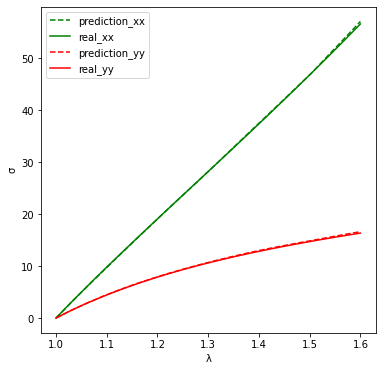

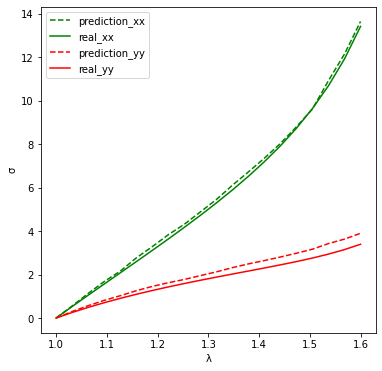

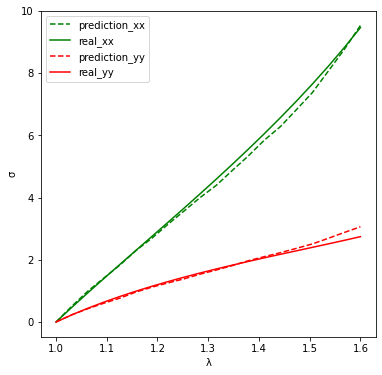

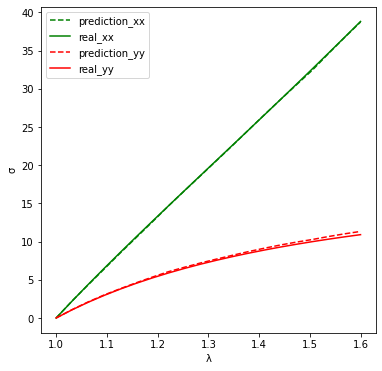

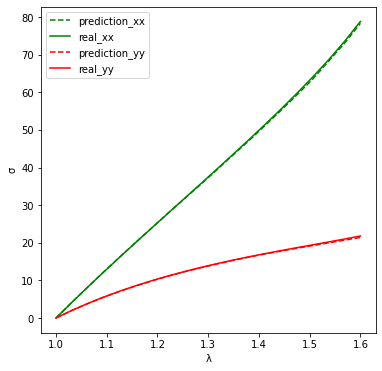

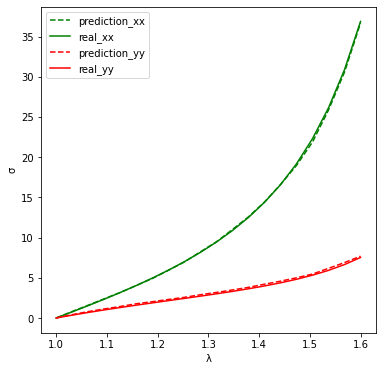

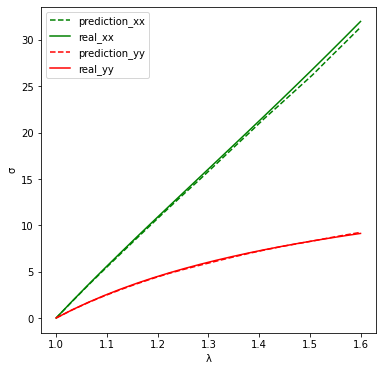

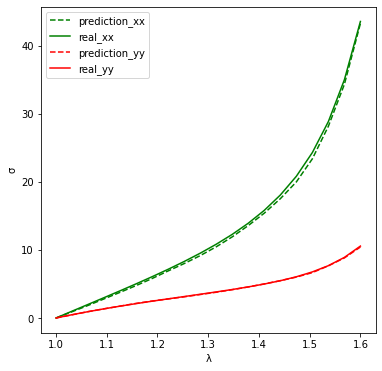

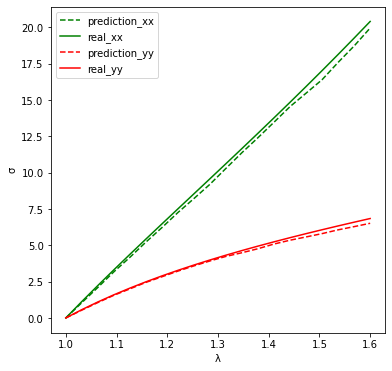

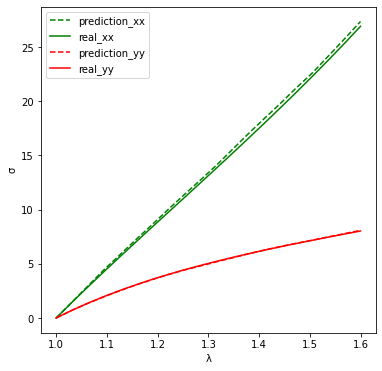

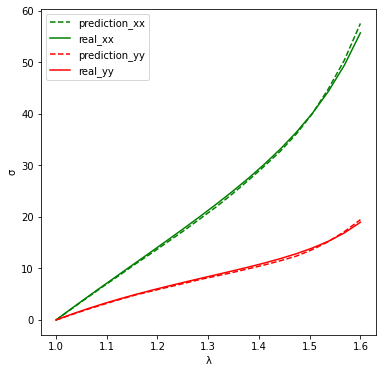

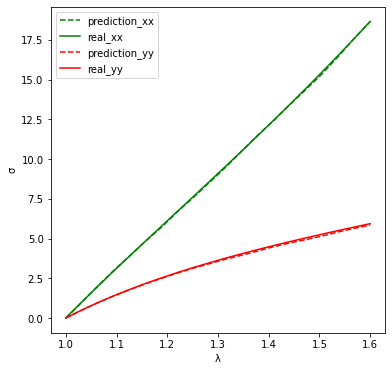

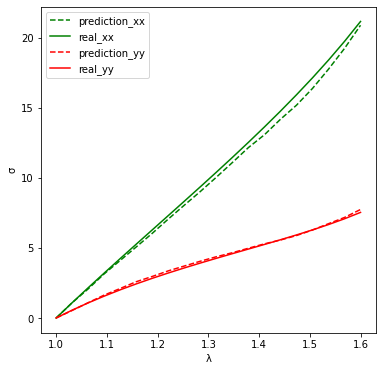

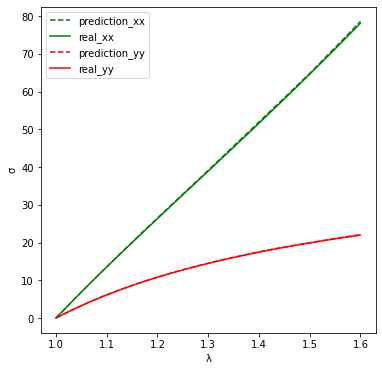

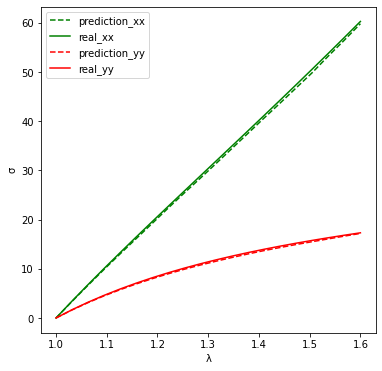

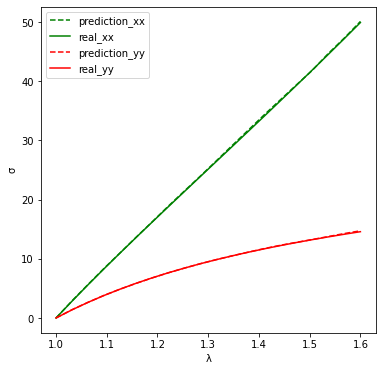

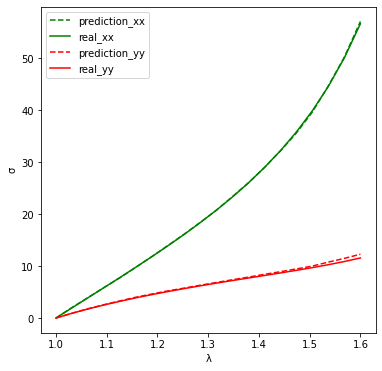

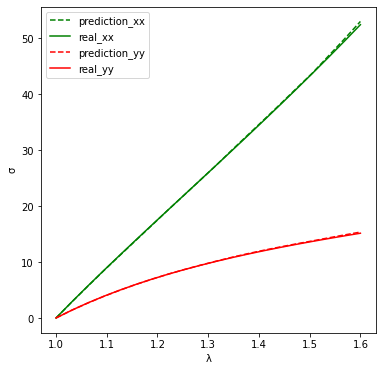

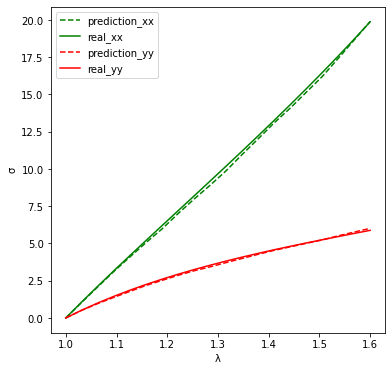

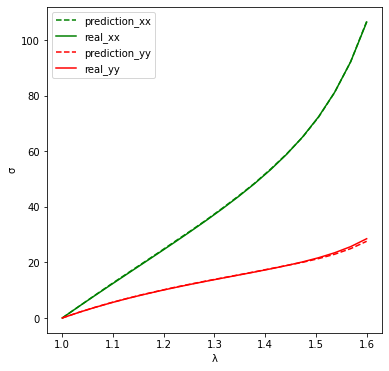

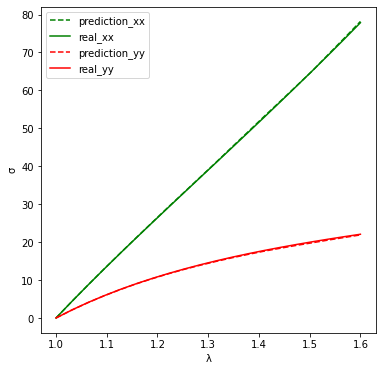

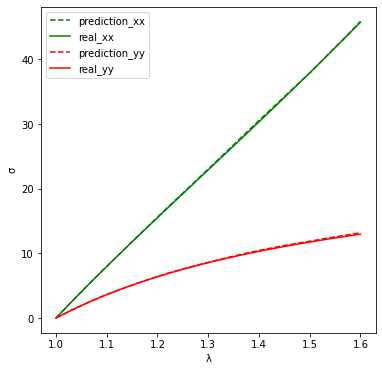

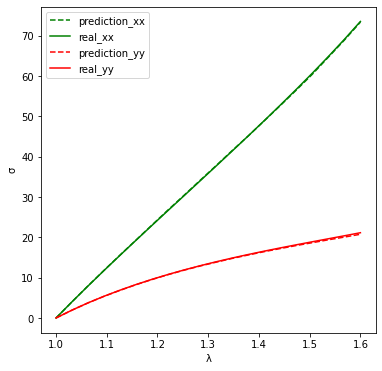

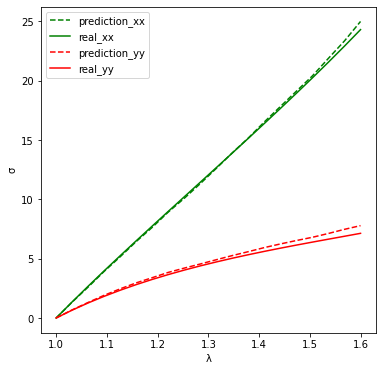

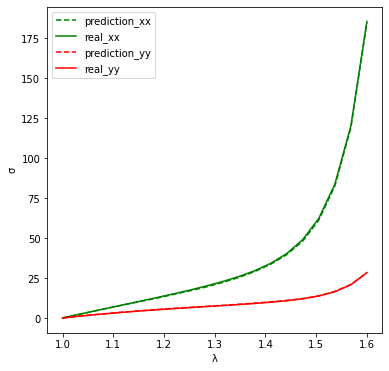

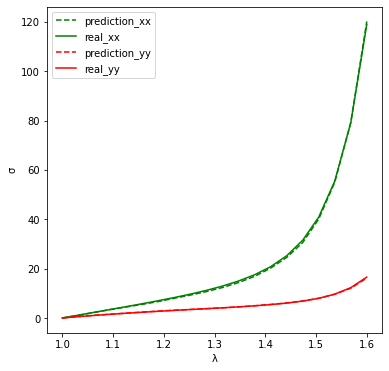

In [56]:
for i in range(30): plot_real_curves(i)

In [57]:
def rel_error(true,guess):
    err = np.abs(true-guess)/np.abs(true)
    return err

### Convert the curves used for testing back into absolute coordinates

In [58]:
def convert_back_curves(y_diff):
    ### Transforms the model's output (which is written in terms of differences between points) back into absolute coordinates.
    
    abs_curves = np.zeros([np.shape(y_diff)[0],np.shape(y_diff)[1]+1])    
    for i in range(len(y_diff)):
        y_abs = np.zeros(np.shape(y_diff)[1]+1)
        for j in range(len(y_diff[0])):
            y_abs[j+1] = y_diff[i][j]+y_abs[j]
        abs_curves[i] = y_abs
    
    return abs_curves

In [59]:
pred_curves_xx = convert_back_curves(model.predict(x_test)[:,:,0])
true_curves_xx = convert_back_curves(y_test[:,:,0])

pred_curves_yy = convert_back_curves(model.predict(x_test)[:,:,1])
true_curves_yy = convert_back_curves(y_test[:,:,1])

### Model evaluation metrics applied on the test set of curves

In [60]:
print("XX DIRECTION")
print('\n')

# RELATIVE ERROR CRITERIA
c = np.average(rel_error(true_curves_xx[:,1:], pred_curves_xx[:,1:]),axis = 1)

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
treshold2 = 0.10
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print("Relative error accuracy =",np.round(100*len(c[c<treshold2])/len(c), decimals = 2),"%, for a treshold of",treshold2*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = r2_score(np.transpose(true_curves_xx[:,1:]), np.transpose(pred_curves_xx[:,1:]), multioutput='raw_values')

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
e = mse(true_curves_xx[:,1:], pred_curves_xx[:,1:]).numpy()

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

print("Average RMSE score: ", np.round(np.sqrt(np.average(e)),decimals=2),'\n')

# MAE CRITERIA
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
f = mae(true_curves_xx[:,1:], pred_curves_xx[:,1:]).numpy()

print("Average MAE score: ", np.round(np.average(f),decimals = 2),'\n')

c_xx = c
d_xx = d
e_xx = e
f_xx = f

XX DIRECTION


Average relative error 4.8 %
Relative error accuracy = 90.93 %, for a treshold of 5.0 %
Relative error accuracy = 95.15 %, for a treshold of 10.0 %


Average R^2 score:  0.7462
R^2 Accuracy = 96.45 %, for a treshold of 0.95


Average MSE score:  1017.69 

Average RMSE score:  31.9 

Average MAE score:  0.57 



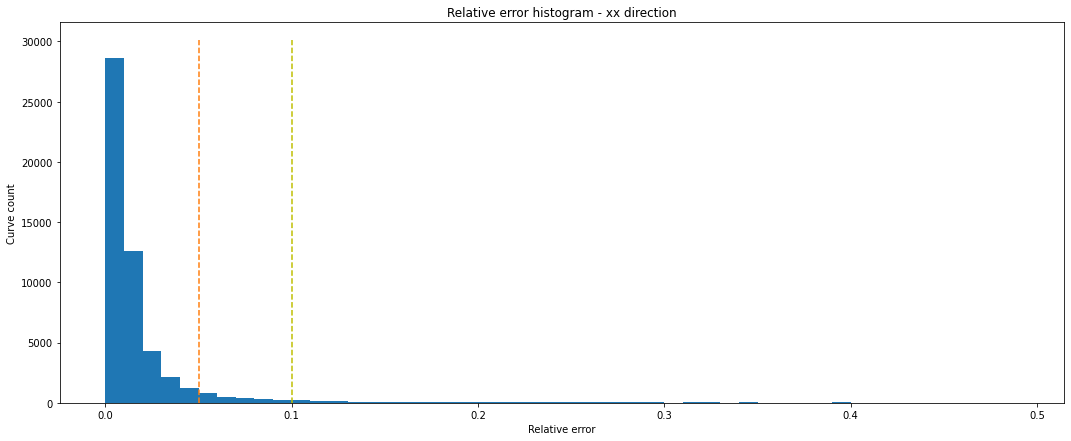

In [61]:
BINS = np.arange(0,0.5,0.01)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(c, bins = BINS,rwidth=1)

m = np.max(np.histogram(c, bins = BINS)[0]) + 0.05*np.max(np.histogram(c, bins = BINS)[0])

plt.plot([0.05,0.05],[0,m], '--', label = "treshold = 0.05")
plt.plot([0.10,0.10],[0,m], '--', color = 'y', label = "treshold = 0.10")

plt.ylabel("Curve count")
plt.xlabel("Relative error")
plt.title("Relative error histogram - xx direction")

plt.show()

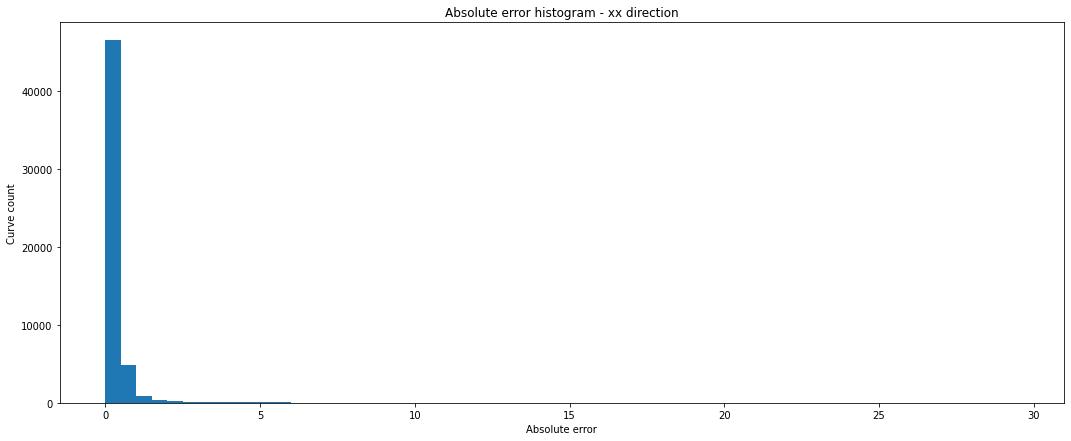

In [62]:
BINS = np.arange(0.0,30.0,0.5)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(f, bins = BINS,rwidth=1)

plt.ylabel("Curve count")
plt.xlabel("Absolute error")
plt.title("Absolute error histogram - xx direction")

plt.show()

In [63]:
print("YY DIRECTION")
print('\n')

# RELATIVE ERROR CRITERIA
c = np.average(rel_error(true_curves_yy[:,1:], pred_curves_yy[:,1:]),axis = 1)

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
treshold2 = 0.10
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print("Relative error accuracy =",np.round(100*len(c[c<treshold2])/len(c), decimals = 2),"%, for a treshold of",treshold2*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = r2_score(np.transpose(true_curves_yy[:,1:]), np.transpose(pred_curves_yy[:,1:]), multioutput='raw_values')

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
e = mse(true_curves_yy[:,1:], pred_curves_yy[:,1:]).numpy()

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

print("Average RMSE score: ", np.round(np.sqrt(np.average(e)),decimals=2),'\n')

# MAE CRITERIA
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
f = mae(true_curves_yy[:,1:], pred_curves_yy[:,1:]).numpy()

print("Average MAE score: ", np.round(np.average(f),decimals = 2),'\n')

c_yy = c
d_yy = d
e_yy = e
f_yy = f

YY DIRECTION


Average relative error 5.23 %
Relative error accuracy = 83.01 %, for a treshold of 5.0 %
Relative error accuracy = 92.0 %, for a treshold of 10.0 %


Average R^2 score:  0.8636
R^2 Accuracy = 91.62 %, for a treshold of 0.95


Average MSE score:  1.51 

Average RMSE score:  1.23 

Average MAE score:  0.17 



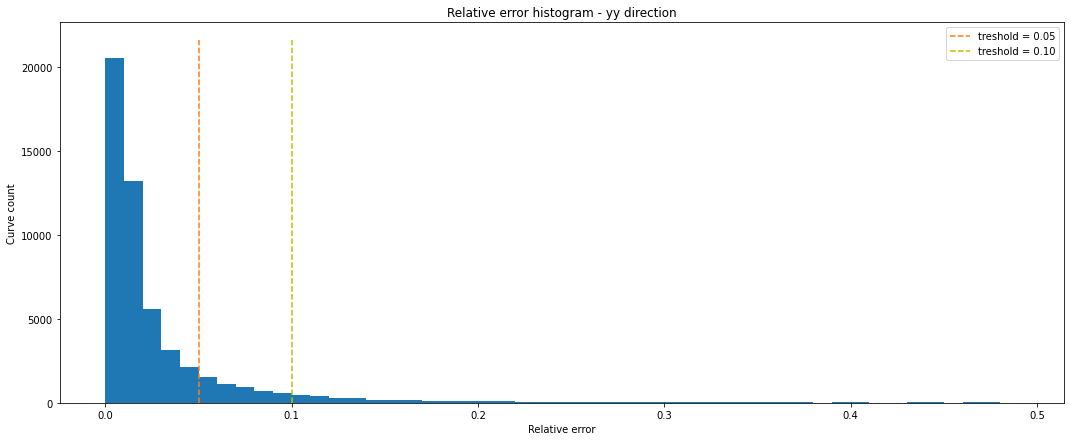

In [64]:
BINS = np.arange(0,0.5,0.01)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(c, bins = BINS,rwidth=1)

m = np.max(np.histogram(c, bins = BINS)[0]) + 0.05*np.max(np.histogram(c, bins = BINS)[0])

plt.plot([0.05,0.05],[0,m], '--', label = "treshold = 0.05")
plt.plot([0.10,0.10],[0,m], '--', color = 'y', label = "treshold = 0.10")

plt.ylabel("Curve count")
plt.xlabel("Relative error")
plt.title("Relative error histogram - yy direction")

plt.legend()
plt.show()

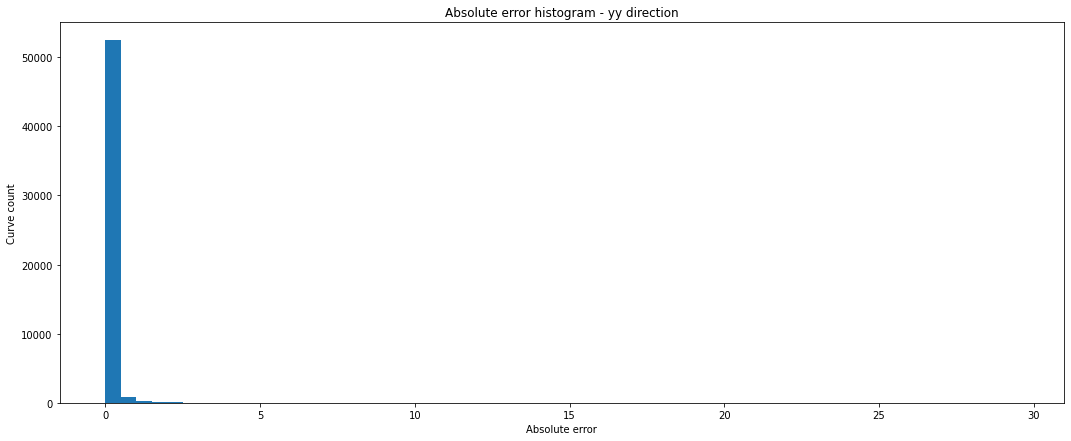

In [65]:
BINS = np.arange(0.0,30.0,0.5)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(f, bins = BINS,rwidth=1)

plt.ylabel("Curve count")
plt.xlabel("Absolute error")
plt.title("Absolute error histogram - yy direction")

plt.show()

In [66]:
print("AVERAGE OF XX AND YY DIRECTIONS")
print('\n')

# RELATIVE ERROR CRITERIA
c = (c_xx + c_yy)/2

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
treshold2 = 0.10
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print("Relative error accuracy =",np.round(100*len(c[c<treshold2])/len(c), decimals = 2),"%, for a treshold of",treshold2*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = (d_xx + d_yy)/2

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
e = (e_xx + e_yy)/2

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

print("Average RMSE score: ", np.round(np.sqrt(np.average(e)),decimals=2),'\n')

# MAE CRITERIA
f = (f_xx + f_yy)/2

print("Average MAE score: ", np.round(np.average(f),decimals = 2),'\n')

AVERAGE OF XX AND YY DIRECTIONS


Average relative error 5.02 %
Relative error accuracy = 87.13 %, for a treshold of 5.0 %
Relative error accuracy = 93.66 %, for a treshold of 10.0 %


Average R^2 score:  0.8049
R^2 Accuracy = 93.88 %, for a treshold of 0.95


Average MSE score:  509.6 

Average RMSE score:  22.57 

Average MAE score:  0.37 



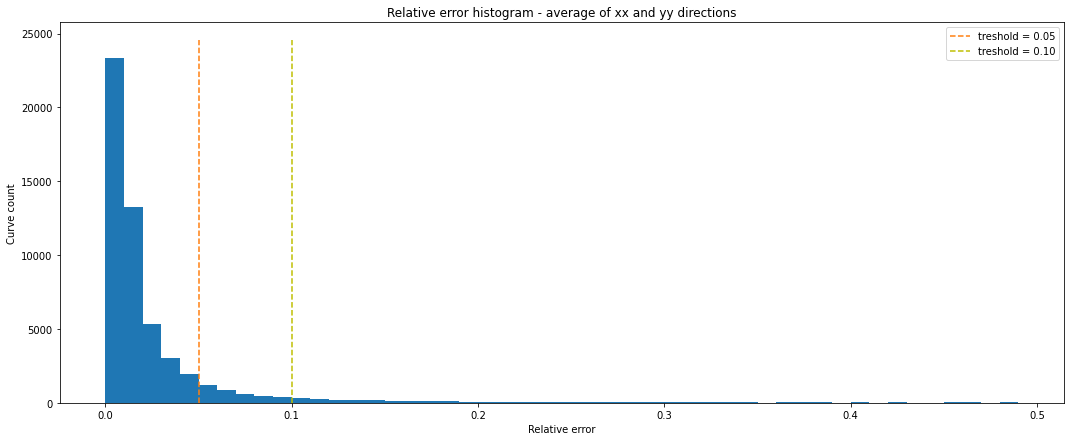

In [67]:
BINS = np.arange(0,0.5,0.01)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(c, bins = BINS,rwidth=1)

m = np.max(np.histogram(c, bins = BINS)[0]) + 0.05*np.max(np.histogram(c, bins = BINS)[0])

plt.plot([0.05,0.05],[0,m], '--', label = "treshold = 0.05")
plt.plot([0.10,0.10],[0,m], '--', color = 'y', label = "treshold = 0.10")

plt.ylabel("Curve count")
plt.xlabel("Relative error")
plt.title("Relative error histogram - average of xx and yy directions")

plt.legend()
plt.show()

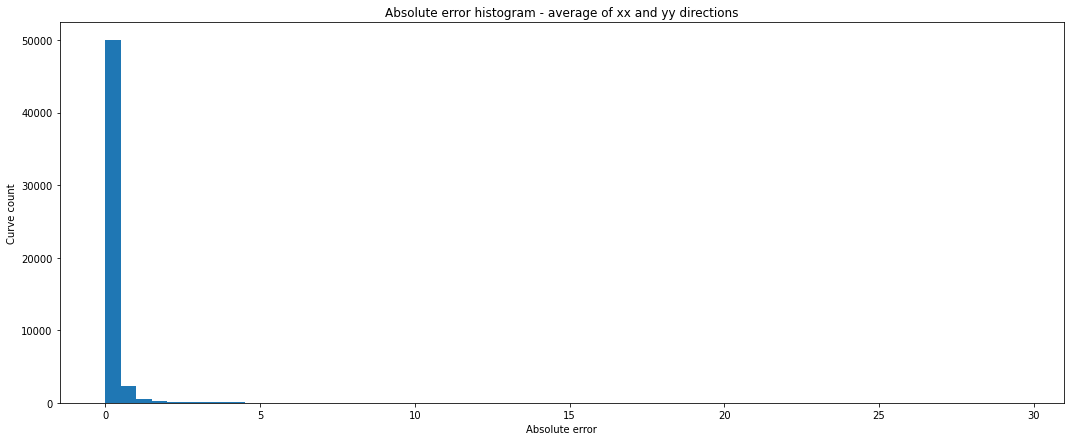

In [68]:
BINS = np.arange(0.0,30.0,0.5)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(f, bins = BINS,rwidth=1)

plt.ylabel("Curve count")
plt.xlabel("Absolute error")
plt.title("Absolute error histogram - average of xx and yy directions")

plt.show()